In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [2]:
import sys
import numpy as np
import time
import os
import sys
import random
import gc
import scipy.ndimage as ndimage
from skimage.transform import resize
import matplotlib.pyplot as plt

from deepmass import map_functions as mf
from deepmass import lens_data as ld
from deepmass import wiener
from deepmass import cnn_keras as cnn

In [3]:
map_size = 128
n_test = int(500)
n_epoch = 50
batch_size = 64
learning_rate = 1e-4

foreground_amplitude_rescale = 253775.
T_mean_cmb = 2.726*1e6

In [4]:
noisy_array = np.load('../foregrounds/foreground_256_041219.npy', mmap_mode='r+')
noisy_array = noisy_array[:12000,:map_size,:map_size].astype(np.float32)
gc.collect()

48

In [5]:
clean_array = np.load('../foregrounds/map_256_041219.npy', mmap_mode='r+')
clean_array = clean_array[:12000,:map_size,:map_size].astype(np.float32)
gc.collect()

28

In [6]:
print(np.std(ndimage.gaussian_filter(noisy_array[0,:,:,0], 1))*foreground_amplitude_rescale)
print(np.std(clean_array))

11608.764431159943
9386.615


In [7]:
for i in range(noisy_array.shape[0]):
    if i%(int(noisy_array.shape[0]/100))==0: print(i, flush=True)
    noisy_array[i,:,:,0] = ndimage.gaussian_filter(noisy_array[i,:,:,0], 1)*foreground_amplitude_rescale
gc.collect()

0
120
240
360
480
600
720
840
960
1080
1200
1320
1440
1560
1680
1800
1920
2040
2160
2280
2400
2520
2640
2760
2880
3000
3120
3240
3360
3480
3600
3720
3840
3960
4080
4200
4320
4440
4560
4680
4800
4920
5040
5160
5280
5400
5520
5640
5760
5880
6000
6120
6240
6360
6480
6600
6720
6840
6960
7080
7200
7320
7440
7560
7680
7800
7920
8040
8160
8280
8400
8520
8640
8760
8880
9000
9120
9240
9360
9480
9600
9720
9840
9960
10080
10200
10320
10440
10560
10680
10800
10920
11040
11160
11280
11400
11520
11640
11760
11880


40

In [8]:
noisy_array = np.add(noisy_array,clean_array)
gc.collect()
noisy_array = (noisy_array-T_mean_cmb)/3e5 +0.5
gc.collect()
clean_array = (clean_array-T_mean_cmb)/3e5 +0.5
gc.collect()

0

In [9]:
test_array_noisy = noisy_array[:n_test]
test_array_clean = clean_array[:n_test]
gc.collect()

20

In [10]:
noisy_array = noisy_array[n_test:]
clean_array = clean_array[n_test:]
gc.collect()

20

(<matplotlib.image.AxesImage at 0x7f43a2375e80>,
 <matplotlib.colorbar.Colorbar at 0x7f43a233c8d0>)

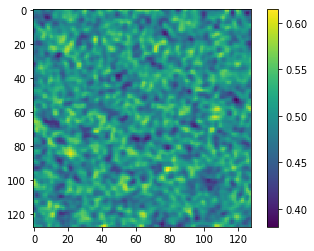

In [11]:
plt.imshow(clean_array[0,:,:,0]), plt.colorbar()

(<matplotlib.image.AxesImage at 0x7f43a1e30c88>,
 <matplotlib.colorbar.Colorbar at 0x7f43a05e8c50>)

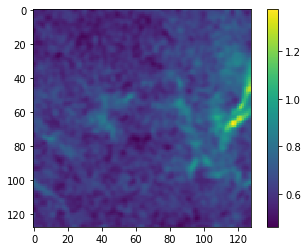

In [12]:
plt.imshow(noisy_array[0,:,:,0]), plt.colorbar()

In [13]:
train_gen = cnn.BatchGenerator(noisy_array, clean_array, gen_batch_size=batch_size)
test_gen = cnn.BatchGenerator(test_array_noisy, test_array_clean, gen_batch_size=batch_size)

cnn_instance = cnn.UnetlikeBaseline(map_size=map_size, learning_rate=learning_rate)
cnn_model = cnn_instance.model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 64, 64, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
history = cnn_model.fit_generator(generator=train_gen,
                         epochs=n_epoch,
                         steps_per_epoch=np.ceil(noisy_array.shape[0] / int(batch_size)),
                         validation_data=test_gen,
                         validation_steps=np.ceil(test_array_noisy.shape[0] / int(batch_size)))

gc.collect()

Epoch 1/50


/obs/njeffrey/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


180/180 [==============================] - 10s 36ms/step - loss: 0.0189 - val_loss: 0.0015
Epoch 2/50
180/180 [==============================] - 6s 35ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 3/50
180/180 [==============================] - 6s 35ms/step - loss: 8.0613e-04 - val_loss: 8.0449e-04
Epoch 4/50
180/180 [==============================] - 6s 34ms/step - loss: 6.3055e-04 - val_loss: 5.6843e-04
Epoch 5/50
180/180 [==============================] - 6s 34ms/step - loss: 5.4141e-04 - val_loss: 4.8938e-04
Epoch 6/50
180/180 [==============================] - 6s 34ms/step - loss: 4.6952e-04 - val_loss: 4.4015e-04
Epoch 7/50
180/180 [==============================] - 6s 35ms/step - loss: 4.3198e-04 - val_loss: 4.1733e-04
Epoch 8/50
180/180 [==============================] - 6s 34ms/step - loss: 4.0475e-04 - val_loss: 3.9846e-04
Epoch 9/50
180/180 [==============================] - 6s 34ms/step - loss: 3.8375e-04 - val_loss: 3.7510e-04
Epoch 10/50
180/180 [========================

50

In [15]:
test_output = cnn_model.predict(test_array_noisy[:50])

In [16]:
target_var = 100*(cnn_model.predict(noisy_array) - clean_array)**2.

In [17]:
test_var = 100*(cnn_model.predict(test_array_noisy) - test_array_clean)**2.

(array([1.494e+04, 9.790e+02, 2.920e+02, 8.500e+01, 4.500e+01, 2.000e+01,
        1.200e+01, 5.000e+00, 4.000e+00, 2.000e+00]),
 array([5.9721117e-10, 6.9817342e-02, 1.3963468e-01, 2.0945202e-01,
        2.7926937e-01, 3.4908670e-01, 4.1890404e-01, 4.8872137e-01,
        5.5853873e-01, 6.2835604e-01, 6.9817340e-01], dtype=float32),
 <a list of 10 Patch objects>)

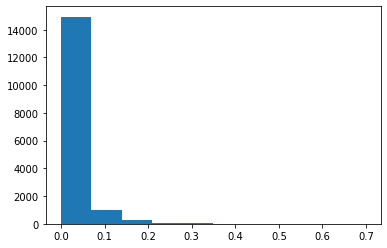

In [18]:
plt.hist(test_var[0,:,:,0].flatten())

(<matplotlib.image.AxesImage at 0x7f44d7544f28>,
 <matplotlib.colorbar.Colorbar at 0x7f44d74f6198>)

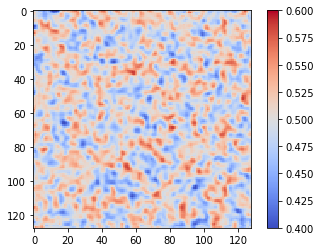

In [19]:
plt.imshow((test_output[0,:,:,0]), cmap='coolwarm', clim=(0.4,0.6)), plt.colorbar()

(<matplotlib.image.AxesImage at 0x7f44d747dbe0>,
 <matplotlib.colorbar.Colorbar at 0x7f44d74385f8>)

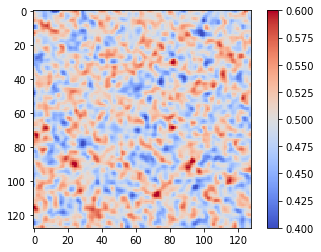

In [20]:
plt.imshow((test_array_clean[0,:,:,0]), cmap='coolwarm', clim=(0.4,0.6)), plt.colorbar()

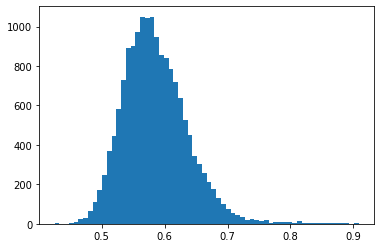

In [21]:
_ = plt.hist(test_array_noisy[0,:,:,0].flatten(), bins=64)

(<matplotlib.image.AxesImage at 0x7f44d72be198>,
 <matplotlib.colorbar.Colorbar at 0x7f44d72ecb38>)

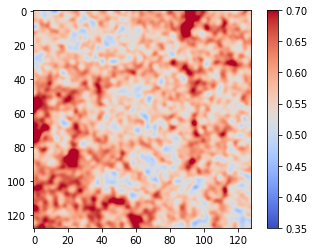

In [22]:
plt.imshow((test_array_noisy[0,:,:,0]), cmap='coolwarm', clim=(0.35,0.7), interpolation='spline16'), plt.colorbar()

(<matplotlib.image.AxesImage at 0x7f44d726e278>,
 <matplotlib.colorbar.Colorbar at 0x7f44d7215b38>)

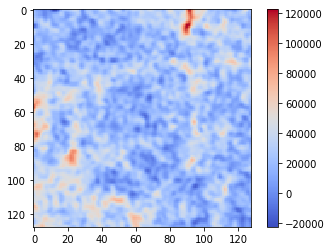

In [23]:
plt.imshow((test_array_noisy[0,:,:,0]-0.5)*3e5, cmap='coolwarm'), plt.colorbar()

(<matplotlib.image.AxesImage at 0x7f44d71999e8>,
 <matplotlib.colorbar.Colorbar at 0x7f44d7142748>)

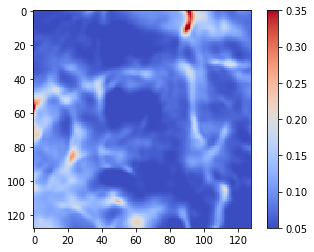

In [24]:
plt.imshow((test_array_noisy[0,:,:,0]-test_array_clean[0,:,:,0]), cmap='coolwarm', clim=(0.05,0.35)), plt.colorbar()

In [25]:
train_gen = cnn.BatchGenerator(noisy_array, target_var, gen_batch_size=batch_size)
test_gen = cnn.BatchGenerator(test_array_noisy, test_var, gen_batch_size=batch_size)

cnn_instance = cnn.UnetlikeBaseline(map_size=map_size, learning_rate=learning_rate)
cnn_model = cnn_instance.model()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 128, 128, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 128, 128, 16) 64          conv2d_10[0][0]                  
__________________________________________________________________________________________________
average_pooling2d_4 (AveragePoo (None, 64, 64, 16)   0           batch_normalization_9[0][0]      
____________________________________________________________________________________________

In [26]:
history = cnn_model.fit_generator(generator=train_gen,
                         epochs=n_epoch,
                         steps_per_epoch=np.ceil(noisy_array.shape[0] / int(batch_size)),
                         validation_data=test_gen,
                         validation_steps=np.ceil(test_array_noisy.shape[0] / int(batch_size)))

gc.collect()

Epoch 1/50
180/180 [==============================] - 7s 36ms/step - loss: 0.1406 - val_loss: 0.0062
Epoch 2/50
180/180 [==============================] - 6s 35ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 3/50
180/180 [==============================] - 6s 35ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 4/50
180/180 [==============================] - 6s 36ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 5/50
180/180 [==============================] - 6s 35ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 6/50
180/180 [==============================] - 6s 35ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 7/50
180/180 [==============================] - 6s 35ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/50
180/180 [==============================] - 6s 35ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 9/50
180/180 [==============================] - 6s 35ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 10/50
180/180 [==============================] - 6s 35ms/step - loss: 0.0016 - val_lo

22016

In [27]:
test_var = cnn_model.predict(test_array_noisy[:50])

(<matplotlib.image.AxesImage at 0x7f44d9587d30>,
 <matplotlib.colorbar.Colorbar at 0x7f44d953e7b8>)

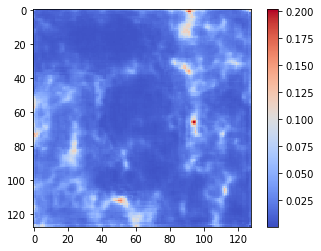

In [28]:
plt.imshow((test_var[0,:,:,0]), cmap='coolwarm'), plt.colorbar()

In [29]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


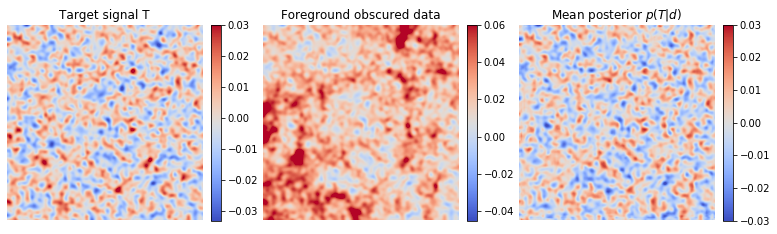

In [30]:
_ = plt.figure(figsize=(13,5))
_ = plt.subplot(1,3,1), plt.imshow((test_array_clean[0,:,:,0]-0.5)*3e5*1e-6, clim=(-0.11*0.3,0.1*0.3),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Target signal T'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,3,2), plt.imshow((test_array_noisy[0,:,:,0]-0.5)*3e5*1e-6, clim=(-0.15*0.3,0.2*0.3),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Foreground obscured data'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,3,3), plt.imshow((test_output[0,:,:,0]-0.5)*3e5*1e-6, clim=(-0.1*0.3,0.1*0.3),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title('Mean posterior $p(T | d)$'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.savefig('reconstruction.png', dpi=300)

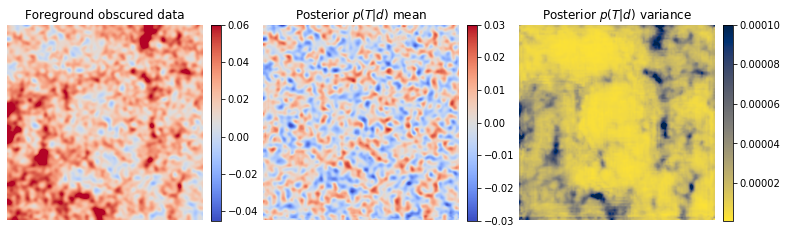

In [39]:
_ = plt.figure(figsize=(13,5))
_ = plt.subplot(1,3,1), plt.imshow((test_array_noisy[0,:,:,0]-0.5)*3e5*1e-6, clim=(-0.15*0.3,0.2*0.3),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Foreground obscured data'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,3,2), plt.imshow((test_output[0,:,:,0]-0.5)*3e5*1e-6, clim=(-0.1*0.3,0.1*0.3),
                                   interpolation='spline16',cmap = 'coolwarm')
_ = plt.title('Posterior $p(T | d)$ mean'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.subplot(1,3,3), plt.imshow((test_var[0,:,:,0]/100.)*(3e5*1e-6)*(3e5*1e-6), clim = (1e-6,1e-4),interpolation='spline16', cmap = 'cividis_r')
_ = plt.title('Posterior $p(T | d)$ variance'), plt.colorbar(fraction=0.046, pad=0.04)
_ = plt.axis('off')
_ = plt.savefig('reconstruction_var.png', dpi=300)